In [1]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

from numba import njit, prange

from sklearn.linear_model import LinearRegression

In [2]:
dt = .001
tau = .1
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 2
bifurcate_time = .8
dip_time = bifurcate_time - .18
sgm = 5
threshold = 70
S = 250
R_initial = 32
eta = S*.03

In [15]:
strong_Tin = [.512]
medium_Tin = [.256, .128, .064]
weak = [.032, 0]
medium_Tout = [-.064, -.128, -.256]
strong_Tout = [-.512]
coh_lst = [strong_Tin, medium_Tin, weak, medium_Tout, strong_Tout]
coh_lst_flat = np.hstack(coh_lst)

In [17]:
@njit(parallel=True, fastmath=True)
def get_dynamic_arr(coh, a, b):

    alpha = a

    trials_RT = np.zeros(int(dur/dt))
    trials_RT[0] = 10240

    RT_arr = np.zeros(int(dur/dt))
    RT_arr.fill(10240)
    RT_arr[0] = 0

    for i in prange(10240):

        beta = 0
        V1, V2 = S, S
        pass_threshold = False

        R1_arr = np.zeros(int(dur/dt))
        R2_arr = np.zeros(int(dur/dt))
        R1_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w11+w12-beta))) / (2*(w11+w12-beta))
        R2_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w22+w21-beta))) / (2*(w22+w21-beta))

        G1_arr = np.zeros(int(dur/dt))
        G2_arr = np.zeros(int(dur/dt))
        G1_arr[0], G2_arr[0] = (w11+w12-beta)*R1_arr[0], (w22+w21-beta)*R2_arr[0]

        D1_arr = np.zeros(int(dur/dt))
        D2_arr = np.zeros(int(dur/dt))
        D1_arr[0], D2_arr[0] = beta*R1_arr[0], beta*R2_arr[0]

        noise_R1 = np.zeros(int(dur/dt))
        noise_R2 = np.zeros(int(dur/dt))
        noise_G1 = np.zeros(int(dur/dt))
        noise_G2 = np.zeros(int(dur/dt))
        noise_D1 = np.zeros(int(dur/dt))
        noise_D2 = np.zeros(int(dur/dt))

        for ti in range(1, int(dur/dt)):

            if ti == int(dip_time/dt):
                    V1, V2 = S/3, S/3

            if ti == bifurcate_time/dt:
                    beta = b
                    V1 = S*(1+coh)
                    V2 = S*(1-coh)

            if ti >= bifurcate_time/dt and ti % 5 == 0:
                    V1 = S*(1+coh) + np.random.randn() * eta
                    V2 = S*(1-coh) + np.random.randn() * eta

            d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tau
            d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tau
            d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tau
            d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tau
            d_D1 = (-D1_arr[ti-1] + beta*R1_arr[ti-1]) *dt/tau
            d_D2 = (-D2_arr[ti-1] + beta*R2_arr[ti-1]) *dt/tau

            noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

            if not pass_threshold:
                trials_RT[ti] += 1
                RT_arr[ti] += R1_arr[ti]

            if R1_arr[ti] > threshold and ti >= bifurcate_time/dt:
                pass_threshold = True

            elif R2_arr[ti] > threshold and ti >= bifurcate_time/dt:
                pass_threshold = True

    return np.divide(RT_arr, trials_RT), trials_RT

In [24]:
def get_full_dynamic(a, b):

    full_dynamic = [i for i in range(len(coh_lst_flat))]
    for i, coh in enumerate(coh_lst_flat):
        cur_dynamic, cur_RT = get_dynamic_arr(coh, a, b)

        stop = 10240-1
        for sec, trial_num in enumerate(cur_RT):
                if trial_num < 10240/2:
                    stop = sec
                    break

        full_dynamic[i] = cur_dynamic[:stop]

    return full_dynamic

In [19]:
def fitted_slope(a, b):
    dynamic = get_full_dynamic(a, b)
    dynamic.reverse()
    slope_arr = [i for i in range(len(coh_lst_flat))]

    lr = LinearRegression()
    for i in range(len(coh_lst_flat)):
        lr.fit(np.arange(0, len(dynamic[i][800:])/1000, .001).reshape(-1, 1), dynamic[i][800:])
        slope_arr[i] = lr.coef_[0]

    return slope_arr

In [20]:
def plot_fitted_buildup_rate(slope_arr, c, l):
    lr = LinearRegression()
    coh_lst_flat_reverse = np.flip(coh_lst_flat)

    lr.fit(coh_lst_flat_reverse.reshape(-1, 1), slope_arr)
    fit_y = lr.predict(coh_lst_flat_reverse.reshape(-1, 1))
    plt.plot(coh_lst_flat_reverse, slope_arr, 'o', color=c)
    plt.plot(coh_lst_flat_reverse, fit_y, color=c, label=l)

In [21]:
accuracy = fitted_slope(25, 1.2)
speed = fitted_slope(25, 1.7)

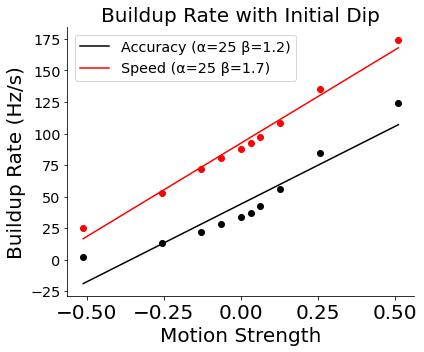

In [22]:
plot_fitted_buildup_rate(accuracy, 'Black', 'Accuracy (α=25 β=1.2)')
plot_fitted_buildup_rate(speed, 'Red', 'Speed (α=25 β=1.7)')
plt.title("Buildup Rate with Initial Dip")
plt.xlabel("Motion Strength")
plt.ylabel("Buildup Rate (Hz/s)")
plt.legend()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

params = {'figure.figsize': (6, 5),
        'legend.fontsize': 'x-large',
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'xtick.labelsize': 20,
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.tight_layout()
plt.savefig("Buildup Rate with Initial Dip.tiff", format="tiff")